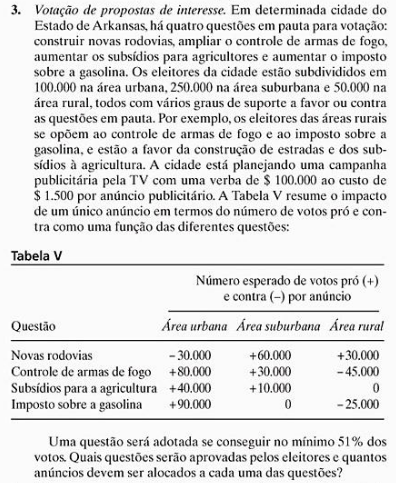

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Campanha_Publicitaria_Arkansas')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores das questões
questoes = ['rodovias', 'armas', 'subsidios', 'gasolina']

# Dados da votação
votos_totais = 100000 + 250000 + 50000
limiar_aprovacao = 0.51
votos_necessarios = votos_totais * limiar_aprovacao # 400.000 * 0.51 = 204.000

# Dados da campanha
orcamento_total = 100000
custo_por_anuncio = 1500
max_anuncios = orcamento_total // custo_por_anuncio # Divisão inteira, resultando em 66 anúncios

# Impacto líquido de votos por anúncio para cada questão
impacto_por_anuncio = {
    'rodovias': -30000 + 60000 + 30000, # 60.000
    'armas': 80000 + 30000 - 45000,     # 65.000
    'subsidios': 40000 + 10000 + 0,      # 50.000
    'gasolina': 90000 + 0 - 25000       # 65.000
}

# Constante "Big M" para as restrições lógicas
# Um valor seguro que seja maior que o máximo de votos possível
BIG_M = votos_totais * 2

In [4]:
# 1. Variáveis de Decisão
# Número de anúncios para cada questão (inteiros)
num_anuncios = model.integer_var_dict(questoes, name='X', lb=0)

# Variável binária que é 1 se a questão for aprovada, 0 caso contrário
aprovada = model.binary_var_dict(questoes, name='Y')


# 2. Função Objetivo
# Maximizar o número de questões aprovadas
soma_aprovadas = model.sum(aprovada[q] for q in questoes)
model.maximize(soma_aprovadas)


# 3. Restrições

# Restrição 1: Orçamento Total da Campanha
# O número total de anúncios não pode exceder o máximo permitido pelo orçamento.
soma_anuncios = model.sum(num_anuncios[q] for q in questoes)
restr_orcamento_logica = soma_anuncios <= max_anuncios
model.add_constraint(restr_orcamento_logica, ctname='limite_orcamento')

# Restrição 2: Lógica de Aprovação (vinculando X e Y)
# Para cada questão, definimos as condições para que Y seja 1.
for q in questoes:
    votos_gerados = impacto_por_anuncio[q] * num_anuncios[q]

    # Se a questão for aprovada (Y[q]=1), o total de votos deve ser >= ao necessário.
    # Se Y[q]=0, esta restrição se torna Votos >= 0, que é sempre verdade.
    restr_link_A = votos_gerados >= votos_necessarios * aprovada[q]
    model.add_constraint(restr_link_A, ctname=f'link_A_{q}')

    # Se a questão NÃO for aprovada (Y[q]=0), o total de votos deve ser < que o necessário.
    # Se Y[q]=0, Votos <= 203999. Se Y[q]=1, Votos <= 203999 + M (não restritivo).
    restr_link_B = votos_gerados <= (votos_necessarios - 1) + BIG_M * aprovada[q]
    model.add_constraint(restr_link_B, ctname=f'link_B_{q}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    questoes_aprovadas_num = model.objective_value
    print(f"Número Máximo de Questões Aprovadas: {int(questoes_aprovadas_num)}\n")

    print("--- Alocação de Anúncios e Status das Questões ---")
    anuncios_totais_usados = 0
    for q in questoes:
        anuncios_val = num_anuncios[q].solution_value
        aprovada_val = "Aprovada" if aprovada[q].solution_value > 0.9 else "Rejeitada"
        anuncios_totais_usados += anuncios_val
        print(f"Questão '{q.capitalize()}':")
        print(f"  - Anúncios Alocados: {int(anuncios_val)}")
        print(f"  - Status Final: {aprovada_val}")

    print(f"\nTotal de Anúncios Utilizados: {int(anuncios_totais_usados)} de {max_anuncios} disponíveis.")

else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 5 rows and 4 columns.
MIP Presolve modified 64 coefficients.
Aggregator did 4 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.02 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.02 ticks)
Parallel b&c, 16 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.02 ticks)

------ SOLUÇÃO ÓTIMA ------

Número Máximo de Questões Aprovadas: 4

--- Alocação de Anúncios e Status das Questões ---
Questão 'Rodovias':
  - Anúncios Alocados: 16
  - Status Final: Aprovada
Questão 'Armas':
  - Anúncios Alocados: 15
  - Status Final: